In [1]:
import pandas as pd
import numpy as np

data = pd.read_parquet("../data/albania_res.parquet")

In [2]:
data.index = pd.to_datetime(data.index, utc="UTC")

In [3]:
from mlpforecast.data.transform import DatasetObjective
from sklearn.preprocessing import MinMaxScaler, RobustScaler

config_dict = {
    "target_series": "NetLoad",
    "unknown_features": ["NetLoad_rolling_mean_win_48", "NetLoad_rolling_mean_win_336"],
    "calender_variable": ["HOUR", "Session"],
    "known_calender_features": ["HOUR-cosin", "Session-cosin"],
    "known_continuous_features": [
        "NetLoad_lag_48",
        "NetLoad_lag_336",
        "Temperature",
        "Humidity",
        "Rain",
    ],
    "input_scaler": RobustScaler(),
    "target_scaler": RobustScaler(),
    "lags": [1, 7],
    "window": [1, 7],
    "window_func": ["mean"],
    "period": "30min",
    "input_window_size": 96,
    "forecast_horizon": 48,
    "date_column": "timestamp",
}

In [4]:
ds = DatasetObjective(**config_dict)

In [5]:
ds.fit(data.reset_index())

DatasetObjective(calender_variable=['HOUR', 'Session'],
                 input_scaler=RobustScaler(),
                 known_calender_features=['HOUR-cosin', 'Session-cosin'],
                 known_continuous_features=['NetLoad_lag_48', 'NetLoad_lag_336',
                                            'Temperature', 'Humidity', 'Rain'],
                 lags=[1, 7], target_scaler=RobustScaler(),
                 unknown_features=['NetLoad_rolling_mean_win_48',
                                   'NetLoad_rolling_mean_win_336'],
                 window=[1, 7])

In [6]:
x, y = ds.fit_transform(data.reset_index())

In [7]:
y.shape

(69648, 48, 1)

In [8]:
import arviz as az
import matplotlib
import matplotlib.pyplot as plt

az.style.use(["science", "arviz-doc", "tableau-colorblind10"])
nice_fonts = {
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05,
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "legend.frameon": False,
}
matplotlib.rcParams.update(nice_fonts)
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats(
    "svg", "pdf", "retina"
)  # For export

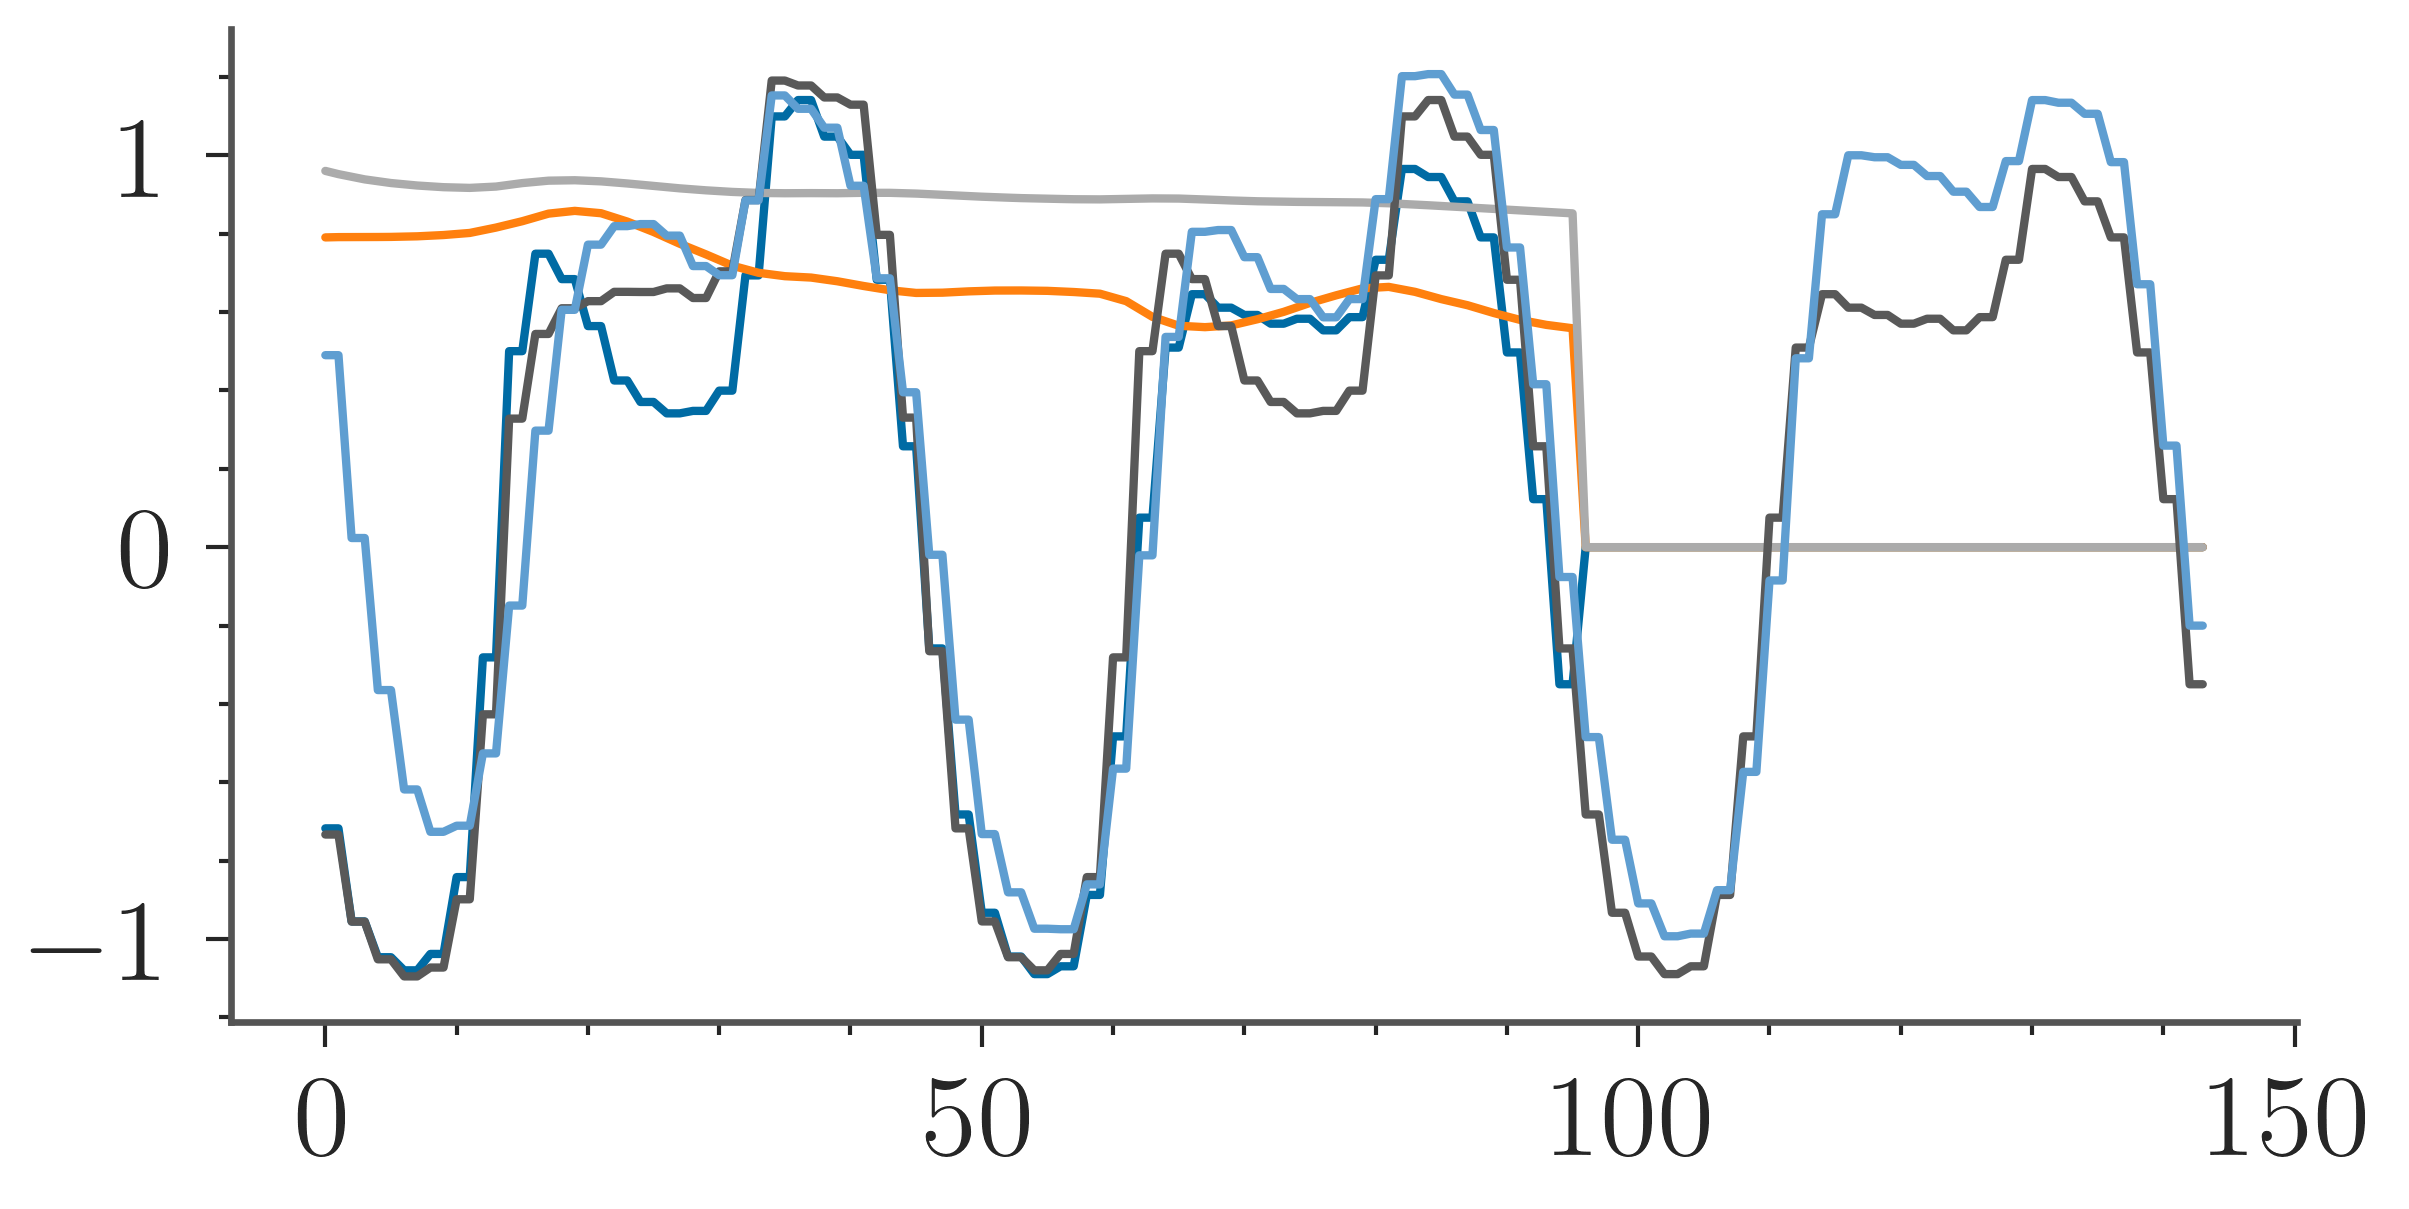

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(x[0, :, :5]);

In [10]:
from mlpforecast.data.loader import TimeseriesDataModule

dl = TimeseriesDataModule(x, y)

In [11]:
x.shape

(69648, 144, 10)

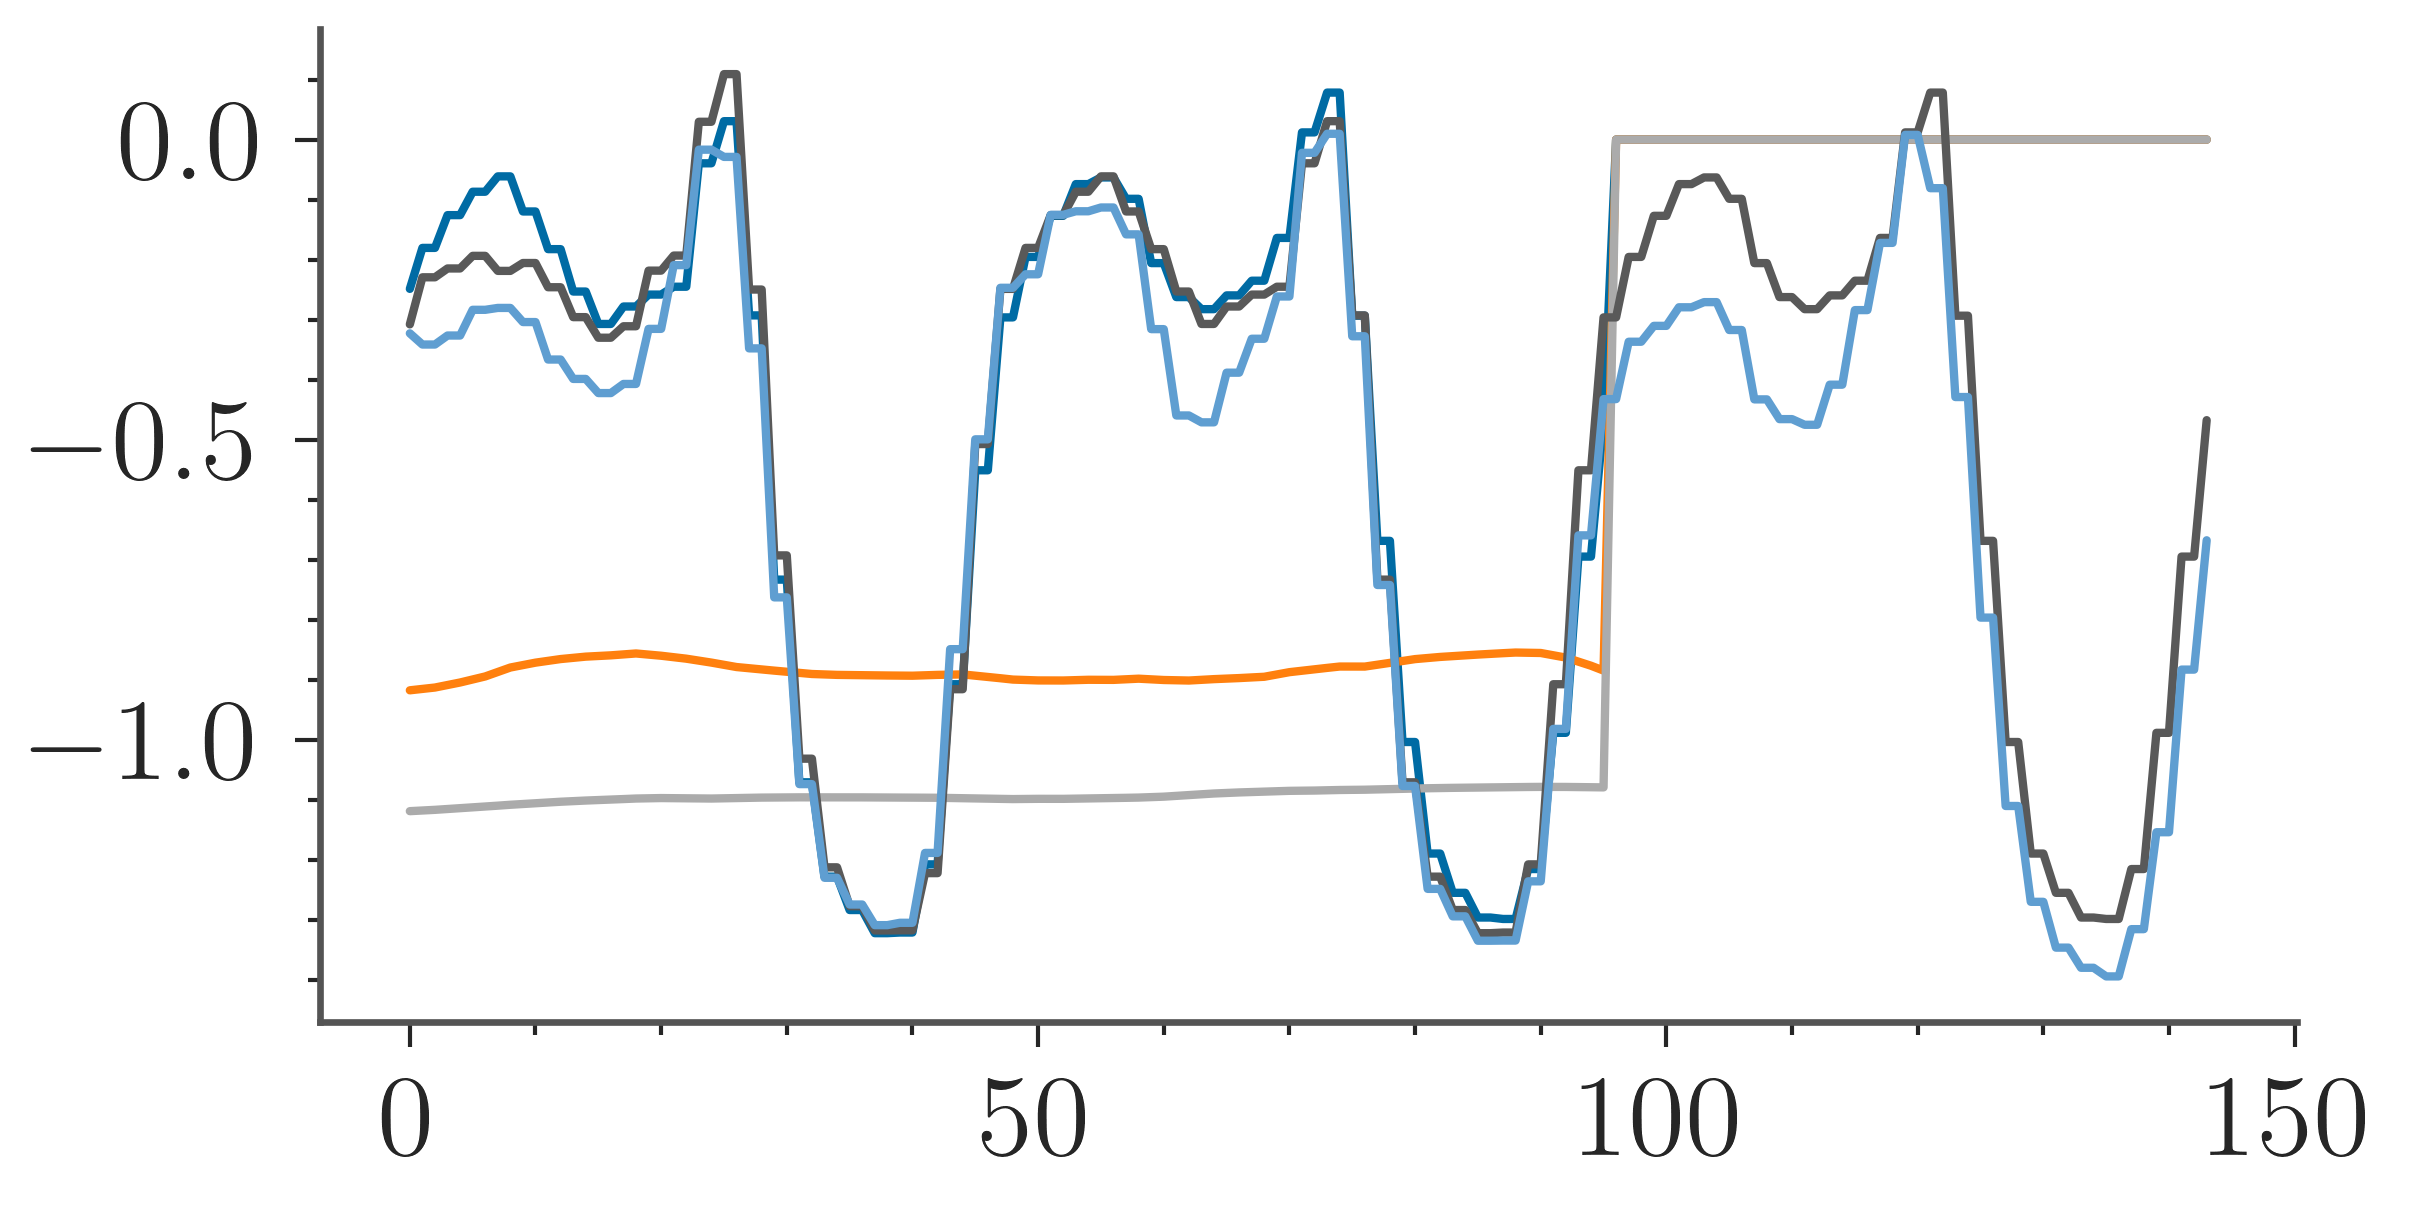

In [12]:
x, y = next(iter(dl.train_dataloader()))
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(x[0, :, :5]);

In [13]:
from mlpforecast.forecaster.mlp import MLPForecast

hparams = {
    "data_pipeline": ds,
    "target_series": "NetLoad",
    "unknown_features": ["NetLoad_rolling_mean_win_48", "NetLoad_rolling_mean_win_336"],
    "known_calender_features": ["HOUR-cosin", "Session-cosin"],
    "known_continuous_features": [
        "NetLoad_lag_48",
        "NetLoad_lag_336",
        "Temperature",
        "Humidity",
        "Rain",
    ],
    "embedding_size": 20,
    "embedding_type": None,
    "combination_type": "additional",
    "hidden_size": 256,
    "num_layers": 2,
    "expansion_factor": 2,
    "residual": False,
    "forecast_horizon": 48,
    "input_window_size": 96,
    "activation_function": "SiLU",
    "out_activation_function": "Identity",
    "dropout_rate": 0.1,
    "alpha": 0.25,
    "max_epochs": 10,
}

model = MLPForecast(hparams=hparams)

In [14]:
model.model.n_out

1

In [15]:
model.fit(data.reset_index()[:20000])

Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:Forecaster:---------------Training started ---------------------------
Restoring states from the checkpoint path at ../checkpoints/Tanesco/default_model/epoch=01.ckpt


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ tra_metric_fcn │ MeanAbsoluteError  │      0 │
│ 1 │ val_metric_fcn │ MeanAbsoluteError  │      0 │
│ 2 │ model          │ MLPForecastNetwork │  1.0 M │
└───┴────────────────┴────────────────────┴────────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4

Restored all states from the checkpoint at ../checkpoints/Tanesco/default_model/epoch=01.ckpt


Output()

/Users/anthonyfaustine/opt/anaconda3/envs/MLPF/lib/python3.11/site-packages/torch/autograd/__init__.py:200: 
UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run 
on the CPU. This may have performance implications. (Triggered internally at 
/Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)

INFO:root:training complete after 0.6644242548665109 minutes


39.865455291990656

In [16]:
x, y = next(iter(model.datamodule.train_dataloader()))

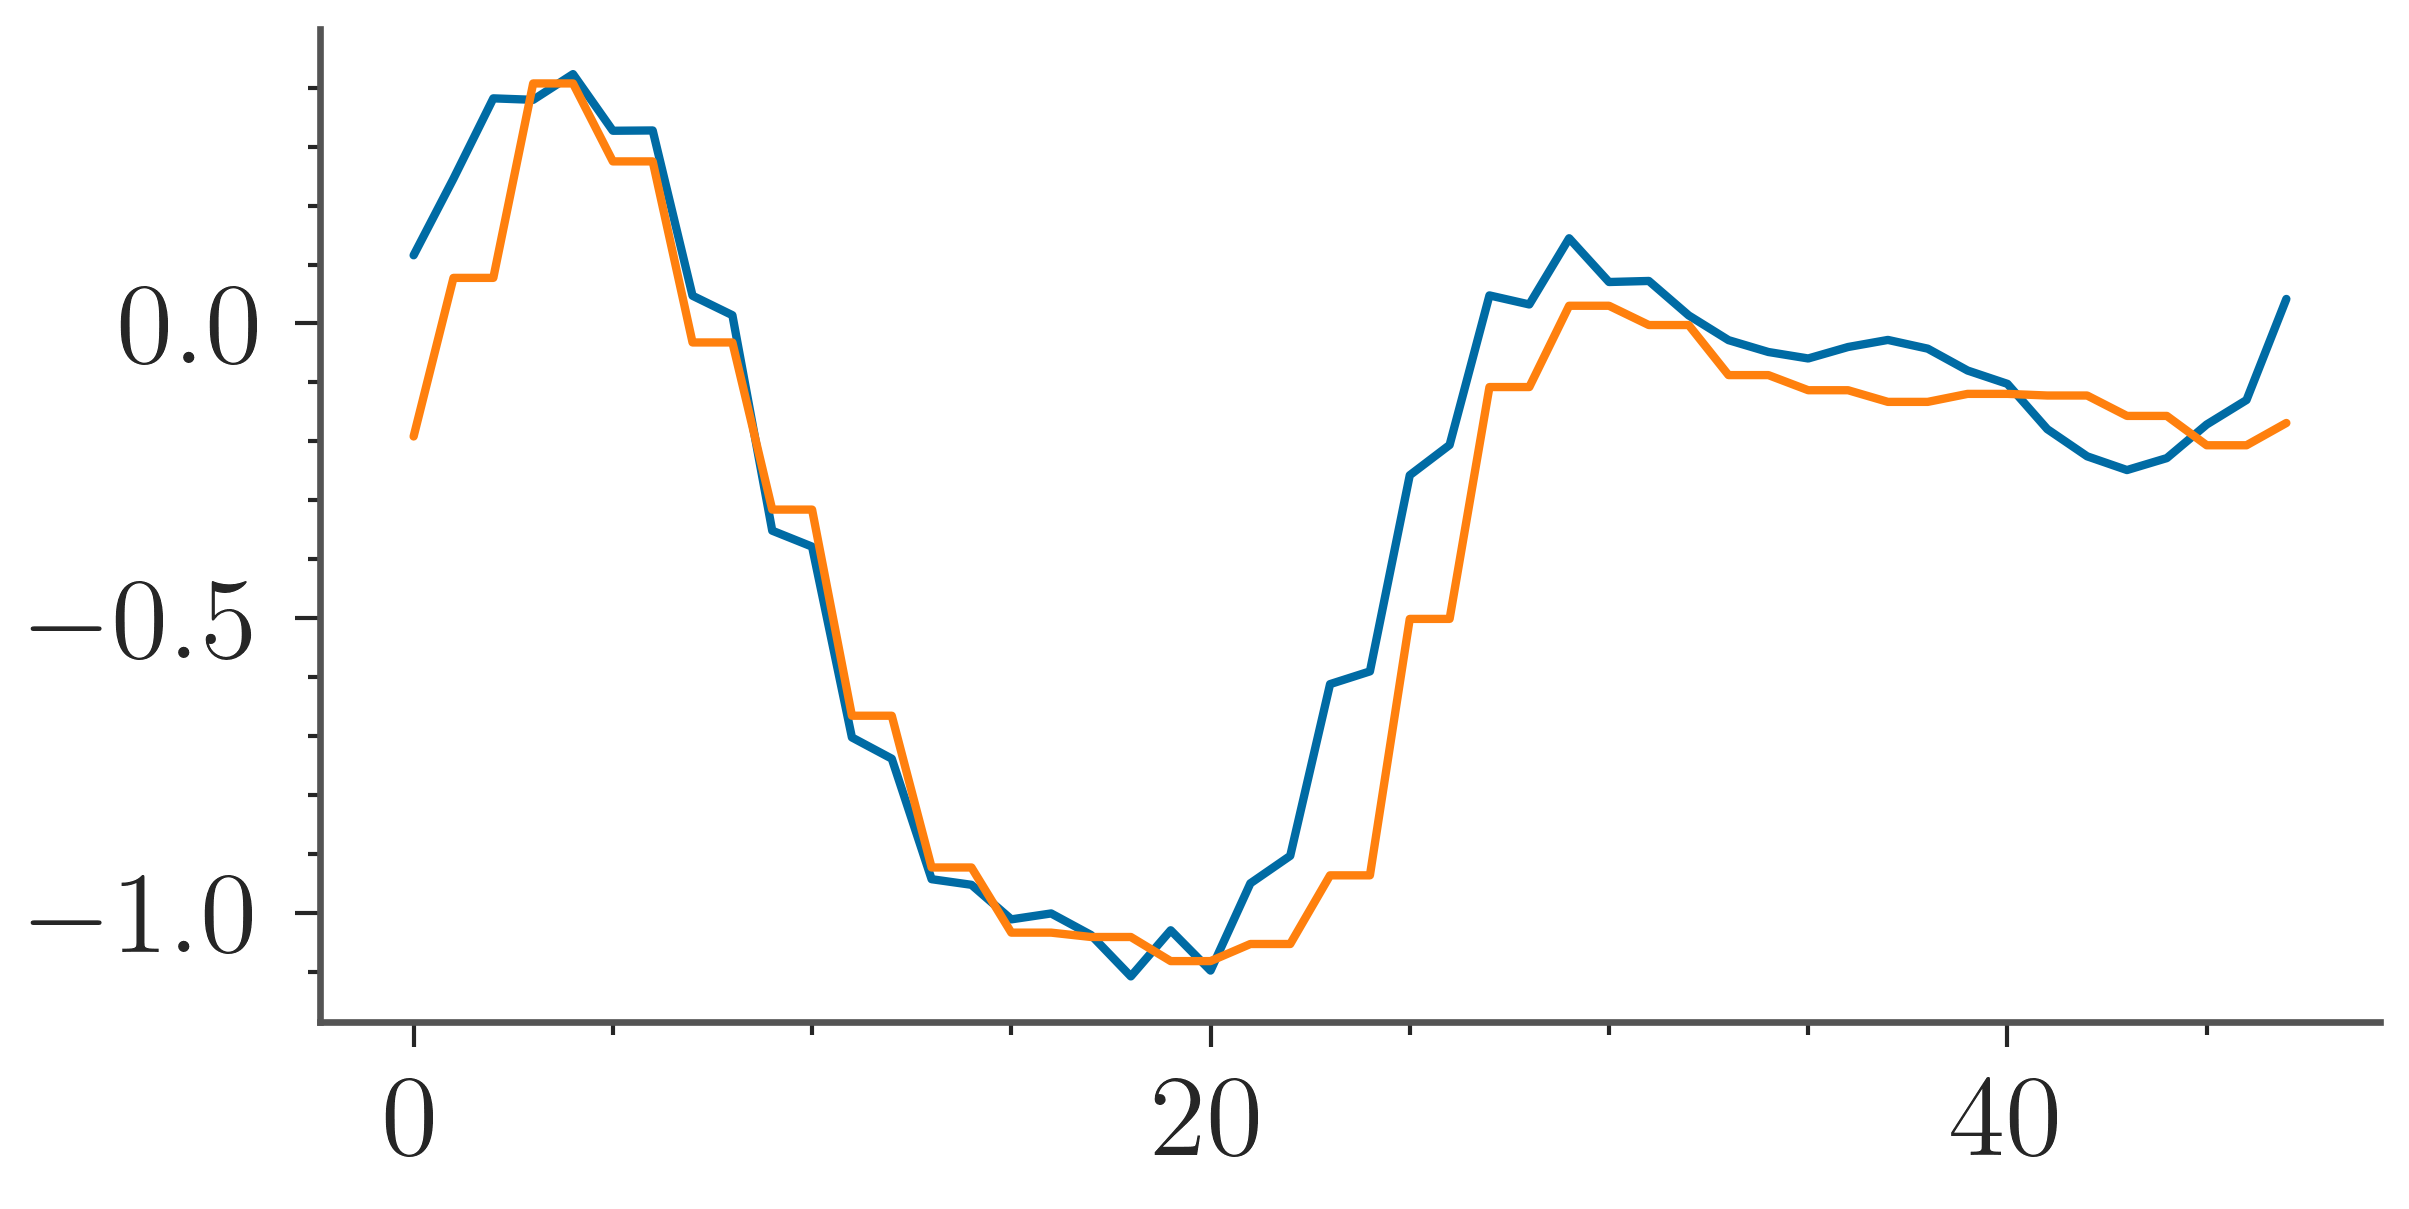

In [17]:
model.model.eval()
pred = model.model.forecast(x)["pred"]
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(pred[0, :, 0])
ax.plot(y[0, :, 0]);

In [18]:
from mlpforecast.forecaster.utils import get_latest_checkpoint, format_target

In [19]:
model.model.data_pipeline

DatasetObjective(calender_variable=['HOUR', 'Session'],
                 input_scaler=RobustScaler(),
                 known_calender_features=['HOUR-cosin', 'Session-cosin'],
                 known_continuous_features=['NetLoad_lag_48', 'NetLoad_lag_336',
                                            'Temperature', 'Humidity', 'Rain'],
                 lags=[1, 7], target_scaler=RobustScaler(),
                 unknown_features=['NetLoad_rolling_mean_win_48',
                                   'NetLoad_rolling_mean_win_336'],
                 window=[1, 7])

In [20]:
path_best_model = get_latest_checkpoint(model.checkpoints)
net = model.model.load_from_checkpoint(path_best_model)
net.eval()
model.model.hparams

"activation_function":       SiLU
"alpha":                     0.25
"combination_type":          additional
"dropout_rate":              0.1
"embedding_size":            20
"embedding_type":            None
"expansion_factor":          2
"forecast_horizon":          48
"gamma":                     0.01
"hidden_size":               256
"input_window_size":         96
"known_calender_features":   ['HOUR-cosin', 'Session-cosin']
"known_continuous_features": ['NetLoad_lag_48', 'NetLoad_lag_336', 'Temperature', 'Humidity', 'Rain']
"learning_rate":             0.001
"max_epochs":                10
"metric":                    mae
"num_attention_heads":       4
"num_layers":                2
"out_activation_function":   Identity
"prob_decay_1":              0.75
"prob_decay_2":              0.9
"residual":                  False
"target_series":             NetLoad
"unknown_features":          ['NetLoad_rolling_mean_win_48', 'NetLoad_rolling_mean_win_336']
"weight_decay":              1e-06

In [21]:
test_df = data.reset_index()[20000:20700]
ground_truth = test_df.iloc[net.data_pipeline.max_data_drop :]
time_stamp = ground_truth[[net.data_pipeline.date_column]]


def format_target(targets, input_window_size, forecast_horizon):
    targets = np.squeeze(
        np.lib.stride_tricks.sliding_window_view(
            targets[input_window_size:],
            (forecast_horizon, targets.shape[1]),
        ),
        axis=1,
    )
    return targets.reshape(targets.shape[0], forecast_horizon, -1)

In [22]:
time_stamp.shape

(364, 1)

In [23]:
ground_truth = format_target(ground_truth, 96, 48)
time_stamp = format_target(time_stamp, 96, 48)

In [24]:
ground_truth

array([[[Timestamp('2017-03-01 16:30:00+0000', tz='UTC'), 20432,
         899.1546516000001, ..., 2017, 'Spring', 1],
        [Timestamp('2017-03-01 17:00:00+0000', tz='UTC'), 20433,
         899.1546516000001, ..., 2017, 'Spring', 1],
        [Timestamp('2017-03-01 17:30:00+0000', tz='UTC'), 20434,
         962.7523800600002, ..., 2017, 'Spring', 1],
        ...,
        [Timestamp('2017-03-02 15:00:00+0000', tz='UTC'), 20477,
         847.6045852199996, ..., 2017, 'Spring', 1],
        [Timestamp('2017-03-02 15:30:00+0000', tz='UTC'), 20478,
         842.88271753, ..., 2017, 'Spring', 1],
        [Timestamp('2017-03-02 16:00:00+0000', tz='UTC'), 20479,
         842.88271753, ..., 2017, 'Spring', 1]],

       [[Timestamp('2017-03-01 17:00:00+0000', tz='UTC'), 20433,
         899.1546516000001, ..., 2017, 'Spring', 1],
        [Timestamp('2017-03-01 17:30:00+0000', tz='UTC'), 20434,
         962.7523800600002, ..., 2017, 'Spring', 1],
        [Timestamp('2017-03-01 18:00:00+0000', tz='

In [25]:
model.predict(data.reset_index()[20000:20700])

({'pred': tensor([[[ 0.5341],
           [ 0.5845],
           [ 0.9261],
           ...,
           [ 0.1958],
           [ 0.3924],
           [ 0.3199]],
  
          [[ 0.6425],
           [ 0.7168],
           [ 1.0161],
           ...,
           [ 0.2072],
           [ 0.4263],
           [ 0.4052]],
  
          [[ 0.8039],
           [ 0.8512],
           [ 1.1447],
           ...,
           [ 0.3081],
           [ 0.5417],
           [ 0.5449]],
  
          ...,
  
          [[-0.9091],
           [-0.7851],
           [-0.5392],
           ...,
           [-1.1078],
           [-1.0471],
           [-1.0101]],
  
          [[-0.6851],
           [-0.4797],
           [-0.2688],
           ...,
           [-1.0692],
           [-0.9506],
           [-0.8428]],
  
          [[-0.4252],
           [-0.2408],
           [-0.0156],
           ...,
           [-1.0277],
           [-0.8250],
           [-0.6890]]])},
 array([[[Timestamp('2017-03-01 16:30:00+0000', tz='UTC')],
  